<a href="https://colab.research.google.com/github/minhht0212/CoderSchool-/blob/main/NBA_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
# Mount to Google Sheets 
from google.colab import auth
auth.authenticate_user()

# Import neccessary libraries -- Đi học syntax 
import gspread
from oauth2client.client import GoogleCredentials
from gspread_dataframe import set_with_dataframe

# Authorize Google Sheets API
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [ ]:
import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

In [ ]:
def export_data_to_new_sheet(gsheet_key, worksheet_name, data):
    """gsheet_key (str): ID of Google Sheet File. (Key is the part behind /d/ and before /edit
                   For example: https://docs.google.com/spreadsheets/d/1WISuNUrWc-7BPO2s-pD3P3qqqgiLh0wRpvTNNtN21gA/edit?usp=sharing
                   Key is 1WISuNUrWc-7BPO2s-pD3P3qqqgiLh0wRpvTNNtN21gA
       worksheet_id (int): 0, 1, 2, ... 
       data (DataFrame): data to write
    """
    sh = gc.open_by_key(gsheet_key)
    
    # To create a new worksheet with 1000 rows and 26 columns
    worksheet = sh.add_worksheet(worksheet_name, 1000, 26)

    # For writing to an existing worksheet
    # worksheet = sh.get_worksheet(0) # --> to get the first worksheet

    set_with_dataframe(worksheet, data)

In [ ]:
# Create a new Google Spreadsheets
sh = gc.create('example') # Thay bằng tên spreadsheet của các bạn 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df_players = pd.read_csv('/content/gdrive/MyDrive/NBA_dataset/players.csv')
df_seasons = pd.read_csv('/content/gdrive/MyDrive/NBA_dataset/seasons.csv')
df_win = pd.read_csv('/content/gdrive/MyDrive/NBA_dataset/Franchise_Win_Totals.csv')
df_definition = pd.read_csv('/content/gdrive/MyDrive/NBA_dataset/keyword_definitions.csv',encoding = 'unicode_escape')

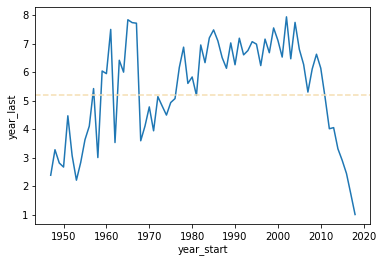

In [ ]:
sns.lineplot(
    data=df_players.groupby(['year_start'])['year_last'].mean().reset_index(), 
    x="year_start", y="year_last")

plt.axhline(df_players['year_last'].mean(), color='wheat', linestyle='--')

In [ ]:
df_players[df_players['year_start'].isin(range(1980,2017))]['year_last'].describe()

count    2529.000000
mean        6.116647
std         4.755934
min         1.000000
25%         2.000000
50%         5.000000
75%        10.000000
max        23.000000
Name: year_last, dtype: float64

# Clean data:
1.   Only choose players that year_start from 1980 to 2017 => remove that players in df_seasons
2.   Remove players that isnull in df_player => remove that players in df_seasons



In [ ]:
df_players['year_last'] = df_players['year_end'] - df_players['year_start'] + 1
#Divide into 2 groups: Group1(players only play less or equal 3 years) and Group2(above 3 years)
def type(cell):
  if cell <= 3: return 1
  else: return 2
df_players['group'] = df_players['year_last'].apply(type)

In [ ]:
#calculate players' age when they were drafted and retired
df_players['birth_date'] = pd.to_datetime(df_players['birth_date']).dt.year
df_players['Age_draft'] =  df_players['year_start'] - df_players['birth_date'] 
df_players['Age_retired'] = df_players['year_end'] - df_players['birth_date']

df_seasons['birth_date'] = df_seasons['Year'] - df_seasons['Age']-1


In [ ]:
#Create playerID to avoid duplicate players' name
df_players['playerID'] = df_players['name'] + '-' + df_players['birth_date'].astype('string')
df_seasons['playerID'] = df_seasons['Player'] + '-' + df_seasons['birth_date'].astype('string')

In [ ]:
#Select players that started to play since 1980
df_players = df_players[df_players['year_start'].isin(range(1980,2018))]
df_seasons = df_seasons[(df_seasons['playerID'].isin(df_players['playerID']))&(df_seasons['Year']>=1980)]

In [ ]:
#change height from feet-inch to cm
df_players['heightincm'] = df_players['height'].str.split('-')
def fttocm(row):
  return int(row['heightincm'][0])*30.48 + int(row['heightincm'][1])*2.54 
df_players['height'] = df_players.apply(fttocm, axis = 1)
df_players.drop(columns='heightincm',inplace=True)

In [ ]:
#Merge group and year_start
df_seasons = pd.merge(df_seasons, df_players[['playerID','group','position','year_start']], how ='left', on ='playerID')

In [ ]:
df_seasons['year_play'] = df_seasons['Year'] - df_seasons['year_start'] + 1
df_players[['year_last', 'Age_draft', 'Age_retired', 'height', 'weight']].corr().style.background_gradient(cmap='Blues')

,year_last,Age_draft,Age_retired,height,weight
year_last,1.000000,-0.293044,0.917511,0.025527,0.019042
Age_draft,-0.293044,1.000000,0.111379,-0.038048,-0.043576
Age_retired,0.917511,0.111379,1.000000,0.010706,0.001666
height,0.025527,-0.038048,0.010706,1.000000,0.812143
weight,0.019042,-0.043576,0.001666,0.812143,1.000000


In [ ]:
df_seasons.corr().style.background_gradient(cmap='Blues')

In [ ]:
df_seasons.sample(5)

,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,...,BLK,TOV,PF,PTS,birth_date,playerID,group,position,year_start,year_play
4536,1996,Matt Fish,C,26.0,DEN,16,0.0,117.0,14.9,0.590,...,6.0,3.0,16,40,1969.0,Matt Fish-1969.0,1,C,1995,2
12341,2011,Nick Young,SG,25.0,WAS,64,40.0,2034.0,14.5,0.538,...,17.0,90.0,144,1115,1985.0,Nick Young-1985.0,2,G-F,2008,4
8899,2005,Josh Howard,SF,24.0,DAL,76,76.0,2446.0,15.8,0.535,...,49.0,122.0,211,958,1980.0,Josh Howard-1980.0,2,F-G,2004,2
4477,1996,Doug Christie,SF,25.0,TOT,55,17.0,1036.0,14.0,0.549,...,19.0,95.0,141,415,1970.0,Doug Christie-1970.0,2,G-F,1993,4
13584,2014,Marcin Gortat,C,29.0,WAS,81,80.0,2655.0,17.6,0.568,...,121.0,126.0,201,1068,1984.0,Marcin Gortat-1984.0,2,C-F,2008,7


# QUESTION 1: Differences between physical stats + age of draft


*   physical
*   age when draft
*   position





## 1. Physical

(1980.0, 2017.0)

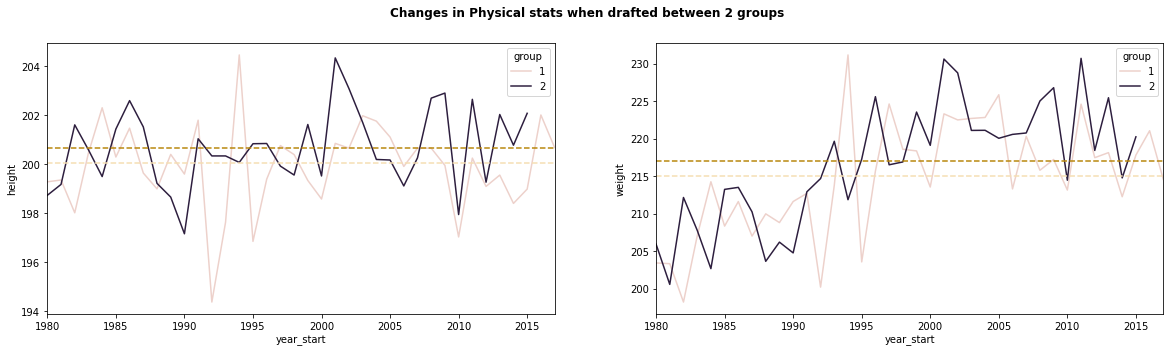

In [ ]:
plt.figure(figsize=(20, 5))
plt.suptitle("Changes in Physical stats when drafted between 2 groups", fontweight='bold')
plt.subplot(121)
sns.lineplot(
    data=df_players.groupby(['year_start','group'])['height'].mean().reset_index(), 
    x="year_start", y="height",
    hue="group")
plt.axhline(df_players[df_players['group']==1]['height'].mean(), color='wheat', linestyle='--')
plt.axhline(df_players[df_players['group']==2]['height'].mean(), color='darkgoldenrod', linestyle='--')
plt.xlim(1980, 2017)

plt.subplot(122)
sns.lineplot(
    data=df_players.groupby(['year_start','group'])['weight'].mean().reset_index(), 
    x="year_start", y="weight",
    hue="group")
plt.axhline(df_players[df_players['group']==1]['weight'].mean(), color='wheat', linestyle='--')
plt.axhline(df_players[df_players['group']==2]['weight'].mean(), color='darkgoldenrod', linestyle='--')
plt.xlim(1980, 2017)

## 2. Age

(1980.0, 2017.0)

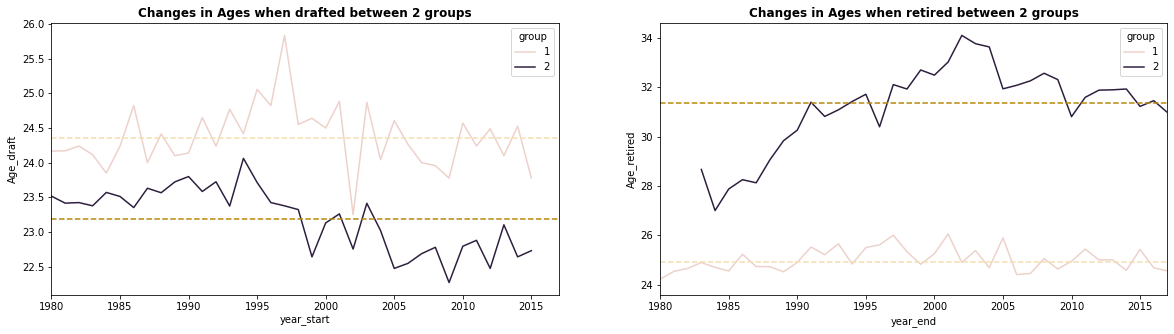

In [ ]:
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.title("Changes in Ages when drafted between 2 groups", fontweight='bold')
sns.lineplot(
    data=df_players[df_players['year_start']<2016].groupby(['year_start','group'])['Age_draft'].mean().reset_index(), 
    x="year_start", y="Age_draft",
    hue="group")
plt.axhline(df_players[(df_players['group']==1)&(df_players['year_start']<2016)]['Age_draft'].mean(), color='wheat', linestyle='--')
plt.axhline(df_players[(df_players['group']==2)&(df_players['year_start']<2016)]['Age_draft'].mean(), color='darkgoldenrod', linestyle='--')
plt.xlim(1980, 2017)



plt.subplot(122)
plt.title("Changes in Ages when retired between 2 groups", fontweight='bold')
sns.lineplot(
    data=df_players.groupby(['year_end','group'])['Age_retired'].mean().reset_index(), 
    x="year_end", y="Age_retired",
    hue="group")
plt.axhline(df_players[df_players['group']==1]['Age_retired'].mean(), color='wheat', linestyle='--')
plt.axhline(df_players[df_players['group']==2]['Age_retired'].mean(), color='darkgoldenrod', linestyle='--')
plt.xlim(1980, 2017)

## 3. Position

In [ ]:
df_players['position'].unique()

array(['F-C', 'G', 'F', 'G-F', 'C', 'F-G', 'C-F'], dtype=object)

Text(0.5, 1.0, 'Group 2')

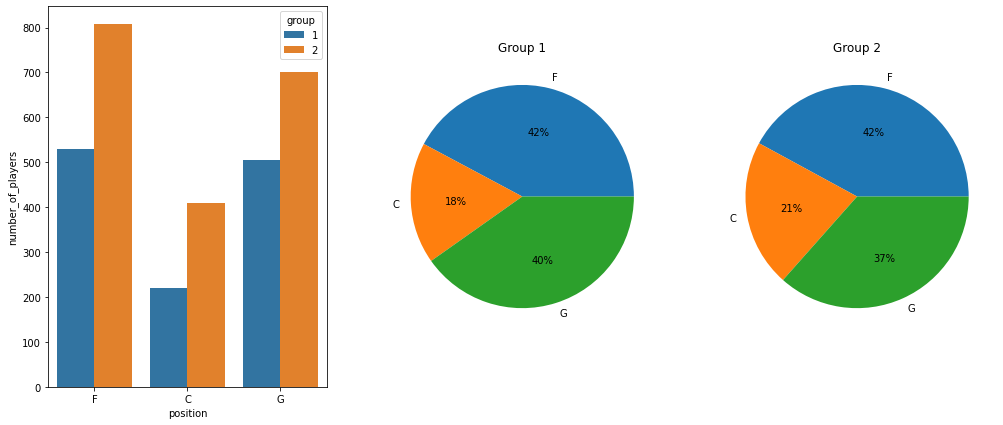

In [ ]:
dfleft = df_players[df_players['position'].str.contains("F")].groupby('group')['position'].count()
dfright = df_players[df_players['position'].str.contains("C")].groupby('group')['position'].count()
df1 = pd.merge(dfleft, dfright, how='inner', 
         left_index=True, right_index=True)
dfright2 = df_players[df_players['position'].str.contains("G")].groupby('group')['position'].count()
df2 = pd.merge(df1, dfright2, how='inner', 
         left_index=True, right_index=True)
df2.columns = ['F','C','G']
df2 = df2.reset_index()
df2 = df2.melt(id_vars='group', 
              value_vars=['F','C','G'],
              var_name='position',
              value_name='number_of_players')

plt.figure(figsize=(17, 7))
plt.subplot(131)
sns.barplot(data=df2,
            x = 'position',
            y = 'number_of_players',
            hue = 'group')

plt.subplot(132)
plt.pie(df2[df2['group']==1]['number_of_players'],labels = df2[df2['group']==1]['position'], autopct = '%0.0f%%')
plt.title("Group 1")

plt.subplot(133)
plt.pie(df2[df2['group']==2]['number_of_players'],labels = df2[df2['group']==1]['position'], autopct = '%0.0f%%')
plt.title("Group 2")

# QUESTION 2: Skills-set range

*   G - C - F (%, attempts - liệu attempt nhiều có tốt ko)
*   PER
*   Skill most effective



In [ ]:
df_playerstats = pd.merge(df_seasons.groupby('playerID').mean().reset_index(), df_players[['playerID','position']], how ='left', on ='playerID')
df_playerstats.corr().style.background_gradient(cmap='Blues')

In [ ]:
df_skillsetall

,BLK%,AST%,TRB%,2P%,FT%,ORB%,DRB%,3P%,TOV%,STL%
group,,,,,,,,,,
1.0,1.539802,7.033697,11.461574,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.0,1.666857,8.941049,11.394030,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.0,2.699091,NaN,NaN,0.435995,0.587045,10.333029,17.864890,NaN,NaN,NaN
2.0,2.960161,NaN,NaN,0.474961,0.654108,9.696416,19.225792,NaN,NaN,NaN
1.0,NaN,16.473058,NaN,NaN,NaN,NaN,NaN,0.239091,17.243282,1.934558
2.0,NaN,18.218032,NaN,NaN,NaN,NaN,NaN,0.292704,15.098037,1.916505


In [ ]:
print(df_playerstats[df_playerstats['position'].str.contains("F")].groupby('group')['BLK%','AST%','TRB%'].mean())
print(df_playerstats[df_playerstats['position'].str.contains("C")].groupby('group')['2P%','FT%','ORB%','DRB%','BLK%'].mean())
print(df_playerstats[df_playerstats['position'].str.contains("G")].groupby('group')['AST%','3P%','TOV%','STL%'].mean())


           BLK%      AST%       TRB%
group                               
1.0    1.539802  7.033697  11.461574
2.0    1.666857  8.941049  11.394030
            2P%       FT%       ORB%       DRB%      BLK%
group                                                    
1.0    0.435995  0.587045  10.333029  17.864890  2.699091
2.0    0.474961  0.654108   9.696416  19.225792  2.960161
            AST%       3P%       TOV%      STL%
group                                          
1.0    16.473058  0.239091  17.243282  1.934558
2.0    18.218032  0.292704  15.098037  1.916505


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
print(df_seasons[(df_seasons['position'].str.contains("F"))&(df_seasons['year_play']==1)].groupby('group')['BLK%','AST%','TRB%'].mean())
print(df_seasons[(df_seasons['position'].str.contains("C"))&(df_seasons['year_play']==1)].groupby('group')['2P%','FT%','ORB%','DRB%','BLK%'].mean())
print(df_seasons[(df_seasons['position'].str.contains("G"))&(df_seasons['year_play']==1)].groupby('group')['AST%','3P%','TOV%','STL%'].mean())

           BLK%      AST%       TRB%
group                               
1      1.647386  6.879933  11.583811
2      1.851613  8.118452  11.729677
            2P%       FT%       ORB%       DRB%      BLK%
group                                                    
1      0.431668  0.579656  10.185903  17.352423  2.655507
2      0.467685  0.636613  10.284091  18.371212  2.981566
            AST%       3P%       TOV%      STL%
group                                          
1      16.608408  0.250307  17.447112  1.937746
2      17.688152  0.259086  16.624681  2.032581


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
print(df_seasons[(df_seasons['position'].str.contains("F"))&(df_seasons['year_play']==2)].groupby('group')['BLK%','AST%','TRB%'].mean())
print(df_seasons[(df_seasons['position'].str.contains("C"))&(df_seasons['year_play']==2)].groupby('group')['2P%','FT%','ORB%','DRB%','BLK%'].mean())
print(df_seasons[(df_seasons['position'].str.contains("G"))&(df_seasons['year_play']==2)].groupby('group')['AST%','3P%','TOV%','STL%'].mean())

           BLK%      AST%       TRB%
group                               
1      1.460714  7.808929  10.403571
2      1.802545  8.682952  11.607761
            2P%       FT%       ORB%       DRB%      BLK%
group                                                    
1      0.443175  0.584131   9.410000  17.986667  2.801667
2      0.483277  0.666474  10.025199  18.792838  3.229178
            AST%       3P%       TOV%      STL%
group                                          
1      15.580345  0.235220  15.894483  2.008276
2      18.439250  0.281936  15.320635  1.985859


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
print(df_seasons[(df_seasons['position'].str.contains("F"))&(df_seasons['year_play']==3)].groupby('group')['BLK%','AST%','TRB%'].mean())
print(df_seasons[(df_seasons['position'].str.contains("C"))&(df_seasons['year_play']==3)].groupby('group')['2P%','FT%','ORB%','DRB%','BLK%'].mean())
print(df_seasons[(df_seasons['position'].str.contains("G"))&(df_seasons['year_play']==3)].groupby('group')['AST%','3P%','TOV%','STL%'].mean())

           BLK%      AST%       TRB%
group                               
1      1.458333  7.276667  10.780000
2      1.776185  9.071090  11.742536
            2P%       FT%       ORB%       DRB%      BLK%
group                                                    
1      0.426510  0.653932  12.888235  22.649020  2.747059
2      0.488653  0.655371  10.359277  19.660723  3.203373
            AST%       3P%       TOV%      STL%
group                                          
1      16.866935  0.256561  17.760656  1.873387
2      18.987761  0.300784  15.059388  1.982197


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


**attempt**


In [ ]:
print(df_playerstats[df_playerstats['position'].str.contains("F")].groupby('group')['BLK','AST','TRB','MP','G'].mean())
print(df_playerstats[df_playerstats['position'].str.contains("C")].groupby('group')['2P','FT','ORB','DRB','BLK','2PA','FTA','MP','G'].mean())
print(df_playerstats[df_playerstats['position'].str.contains("G")].groupby('group')['AST','3P','TOV','STL','3PA','MP','G'].mean())

             BLK        AST         TRB           MP          G
group                                                          
1.0     7.654942  18.276144   65.686510   335.520475  26.195189
2.0    26.447741  73.441279  226.605016  1130.885162  50.603822
               2P         FT        ORB         DRB        BLK         2PA  \
group                                                                        
1.0     38.586398  19.628124  23.512152   48.017692  10.788944   78.642209   
2.0    152.876965  79.132194  87.622053  182.531652  42.870979  306.282289   

              FTA           MP          G  
group                                      
1.0     29.229231   284.340948  23.805292  
2.0    114.835874  1033.595366  48.819379  
              AST         3P        TOV        STL         3PA           MP  \
group                                                                         
1.0     41.250642   9.134550  24.697292  13.646764   29.128832   353.623858   
2.0    145.946012 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
print(df_seasons[(df_seasons['position'].str.contains("F"))&(df_seasons['year_play']==1)].groupby('group')['BLK','AST','TRB','MP','G'].mean())
print(df_seasons[(df_seasons['position'].str.contains("C"))&(df_seasons['year_play']==1)].groupby('group')['2P','FT','ORB','DRB','BLK','2PA','FTA','MP','G'].mean())
print(df_seasons[(df_seasons['position'].str.contains("G"))&(df_seasons['year_play']==1)].groupby('group')['AST','3P','TOV','STL','3PA','MP','G'].mean())

             BLK        AST         TRB           MP          G
group                                                          
1       7.636364  17.792929   64.361953   333.099327  25.917508
2      26.885161  60.625806  213.051613  1022.903226  52.969032
               2P         FT        ORB         DRB        BLK         2PA  \
group                                                                        
1       37.559471  18.330396  23.348018   46.784141  10.876652   78.162996   
2      129.222222  68.053030  79.348485  146.752525  39.886364  263.219697   

              FTA          MP          G  
group                                     
1       28.132159  283.674009  24.352423  
2      102.363636  883.452020  49.020202  
              AST         3P        TOV        STL        3PA          MP  \
group                                                                       
1       42.910714   9.328571  26.780357  14.298214  29.616071  374.019643   
2      122.194640  21.602257

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
print(df_seasons[(df_seasons['position'].str.contains("F"))&(df_seasons['year_play']==2)].groupby('group')['BLK','AST','TRB','MP','G'].mean())
print(df_seasons[(df_seasons['position'].str.contains("C"))&(df_seasons['year_play']==2)].groupby('group')['2P','FT','ORB','DRB','BLK','2PA','FTA','MP','G'].mean())
print(df_seasons[(df_seasons['position'].str.contains("G"))&(df_seasons['year_play']==2)].groupby('group')['AST','3P','TOV','STL','3PA','MP','G'].mean())

             BLK        AST         TRB           MP          G
group                                                          
1       9.289286  22.046429   80.214286   403.507143  29.100000
2      32.464377  80.208651  259.838422  1272.058524  55.936387
               2P         FT         ORB         DRB        BLK         2PA  \
group                                                                         
1       53.591667  27.408333   31.750000   65.158333  13.891667  107.025000   
2      183.816976  95.981432  105.970822  207.323607  54.363395  367.880637   

              FTA           MP          G  
group                                      
1       39.566667   382.958333  28.608333  
2      140.779841  1208.328912  56.461538  
              AST         3P        TOV        STL        3PA           MP  \
group                                                                        
1       46.482759  10.875862  28.162069  16.044828  34.268966   415.555172   
2      157.477633

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
print(df_seasons[(df_seasons['position'].str.contains("F"))&(df_seasons['year_play']==3)].groupby('group')['BLK','AST','TRB','MP','G'].mean())
print(df_seasons[(df_seasons['position'].str.contains("C"))&(df_seasons['year_play']==3)].groupby('group')['2P','FT','ORB','DRB','BLK','2PA','FTA','MP','G'].mean())
print(df_seasons[(df_seasons['position'].str.contains("G"))&(df_seasons['year_play']==3)].groupby('group')['AST','3P','TOV','STL','3PA','MP','G'].mean())

             BLK        AST        TRB           MP          G
group                                                         
1       5.816667  15.041667   50.55000   274.733333  23.275000
2      32.576832  82.539007  260.98818  1278.635934  54.183215
               2P         FT         ORB         DRB        BLK         2PA  \
group                                                                         
1       22.196078  13.274510   15.941176   29.392157   7.215686   47.529412   
2      179.821687  96.546988  103.824096  206.477108  52.884337  358.043373   

              FTA           MP          G  
group                                      
1       20.725490   186.549020  17.882353  
2      140.824096  1185.971084  53.419277  
              AST         3P        TOV        STL         3PA           MP  \
group                                                                         
1       33.306452   7.927419  18.040323  10.129032   24.500000   275.185484   
2      173.019444 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df_seasons[df_seasons['year_play']<=3].groupby(['year_play','group'])['Age','G','MP','PER'].mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


Age          G           MP        PER
year_play group                                              
1         1      23.218548  25.724194   327.156452   8.684814
          2      22.252889  50.439837   958.440517  11.507342
2         1      23.903716  28.625000   391.859797   8.978378
          2      23.222759  54.524138  1225.207586  12.531310
3         1      24.848249  22.245136   272.346304   9.048638
          2      24.164179  53.479559  1253.378326  13.279727

In [ ]:
print(df_playerstats[df_playerstats['position'].str.contains("F")].groupby('group')['Age','G','MP','PER'].mean())
print(df_playerstats[df_playerstats['position'].str.contains("C")].groupby('group')['Age','G','MP','PER'].mean())
print(df_playerstats[df_playerstats['position'].str.contains("G")].groupby('group')['Age','G','MP','PER'].mean())

             Age          G           MP        PER
group                                              
1.0    23.382523  26.195189   335.520475   9.131713
2.0    26.254427  50.603822  1130.885162  12.345793
             Age          G           MP        PER
group                                              
1.0    23.837235  23.805292   284.340948   9.076261
2.0    26.380676  48.819379  1033.595366  12.372810
             Age         G           MP        PER
group                                             
1.0    23.500402  26.50336   353.623858   8.100683
2.0    26.199144  49.74657  1158.351849  11.903272


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df_wins = df_win.head(42).tail(39).reset_index().drop(columns = ['index','Rk'])

In [ ]:
df_wins[['Season','delete']] = df_wins['Season'].str.split('-', expand=True)
df_wins.drop(columns = 'delete', inplace = True)

In [ ]:
df_wins = df_wins.melt(id_vars=df_wins.columns[:2], 
                       value_vars=df_wins.columns[2:],
                       var_name='Tm',
                       value_name='wins')

In [ ]:
df_wins['ranking'] = df_wins.groupby('Season')['wins'].rank(method = 'dense', ascending=False)

In [ ]:
df_wins['Season'] = df_wins['Season'].astype('int')

In [ ]:
df_tmranking = pd.merge(df_seasons[df_seasons['year_play']<=3],df_wins,how ='left', left_on=['Year','Tm'], right_on=['Season','Tm'] )
df_tmranking.sample(5)

,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,...,birth_date,playerID,group,position,year_start,year_play,Season,Lg,wins,ranking
4487,2007,Pape Sow,C,25.0,TOR,7,0.0,34.0,16.4,0.430,...,1981.0,Pape Sow-1981.0,1,F,2005,3,2007.0,NBA,41.0,13.0
1771,1992,Tate George,SG,23.0,NJN,70,2.0,1037.0,11.8,0.483,...,1968.0,Tate George-1968.0,2,G,1991,2,NaN,NaN,NaN,NaN
2074,1994,Sam Cassell,PG,24.0,HOU,66,6.0,1122.0,13.1,0.506,...,1969.0,Sam Cassell-1969.0,2,G,1994,1,1994.0,NBA,47.0,9.0
1310,1989,Craig Neal,PG,24.0,MIA,32,0.0,341.0,7.9,0.458,...,1964.0,Craig Neal-1964.0,1,G,1989,1,1989.0,NBA,18.0,20.0
1183,1988,Kenny Walker,SF,23.0,NYK,82,61.0,2139.0,12.3,0.512,...,1964.0,Kenny Walker-1964.0,2,F,1987,2,1988.0,NBA,52.0,4.0


In [ ]:
df_tmranking.groupby(['group','year_play'])['playerID','ranking'].agg({'playerID':'count','ranking':'mean'})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


playerID    ranking
group year_play                     
1     1              1240  11.788746
      2               592  12.502242
      3               257  12.247312
2     1              1471  11.460711
      2              1450  11.476068
      3              1541  11.279264

In [ ]:
df_playeroff= df_tmranking[(df_tmranking['group']==1)&(~df_tmranking['playerID'].isin(df_tmranking[(df_tmranking['group']==1)&(df_tmranking['year_play']>=2)]['playerID']))]
df_playeroff['year_play'].count()

713

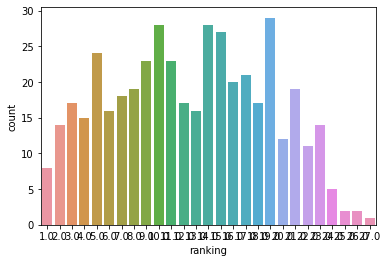

In [ ]:
sns.countplot(data=df_tmranking[(df_tmranking['group']==1)&(df_tmranking['year_play']==2)],
              x='ranking')

# conclusion




(1980.0, 2017.0)

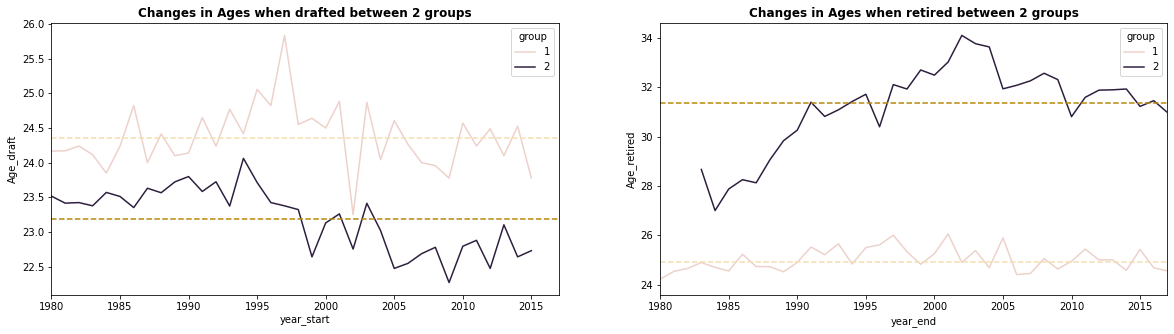

In [ ]:
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.title("Changes in Ages when drafted between 2 groups", fontweight='bold')
sns.lineplot(
    data=df_players[df_players['year_start']<2016].groupby(['year_start','group'])['Age_draft'].mean().reset_index(), 
    x="year_start", y="Age_draft",
    hue="group")
plt.axhline(df_players[(df_players['group']==1)&(df_players['year_start']<2016)]['Age_draft'].mean(), color='wheat', linestyle='--')
plt.axhline(df_players[(df_players['group']==2)&(df_players['year_start']<2016)]['Age_draft'].mean(), color='darkgoldenrod', linestyle='--')
plt.xlim(1980, 2017)

plt.subplot(122)
plt.title("Changes in Ages when retired between 2 groups", fontweight='bold')
sns.lineplot(
    data=df_players.groupby(['year_end','group'])['Age_retired'].mean().reset_index(), 
    x="year_end", y="Age_retired",
    hue="group")
plt.axhline(df_players[df_players['group']==1]['Age_retired'].mean(), color='wheat', linestyle='--')
plt.axhline(df_players[df_players['group']==2]['Age_retired'].mean(), color='darkgoldenrod', linestyle='--')
plt.xlim(1980, 2017)

   year_play  group        Age          G           MP        PER
0          1      1  23.218548  25.724194   327.156452   8.684814
1          1      2  22.252889  50.439837   958.440517  11.507342
2          2      1  23.903716  28.625000   391.859797   8.978378
3          2      2  23.222759  54.524138  1225.207586  12.531310
4          3      1  24.848249  22.245136   272.346304   9.048638
5          3      2  24.164179  53.479559  1253.378326  13.279727


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  from ipykernel import kernelapp as app


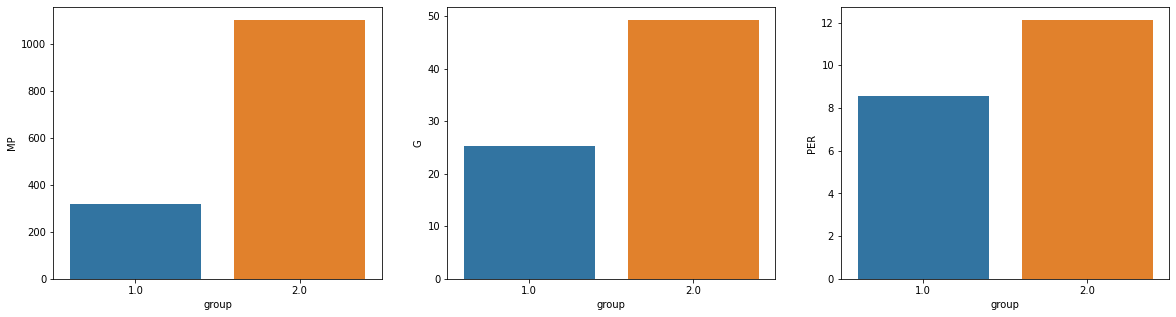

In [ ]:
print(df_seasons[df_seasons['year_play']<=3].groupby(['year_play','group'])['Age','G','MP','PER'].mean().reset_index())

plt.figure(figsize=(20, 5))
plt.subplot(131)
sns.barplot(data=df_playerstats.groupby('group')['MP','G','PER'].mean().reset_index(),
            x = 'group',
            y = 'MP')

plt.subplot(132)
sns.barplot(data=df_playerstats.groupby('group')['MP','G','PER'].mean().reset_index(),
            x = 'group',
            y = 'G')

plt.subplot(133)
sns.barplot(data=df_playerstats.groupby('group')['MP','G','PER'].mean().reset_index(),
            x = 'group',
            y = 'PER')

In [ ]:
mydict ={'MMP_all_24t':[df_seasons[df_seasons['Age']==23]['MP'].mean()],               
         'MMP_draft_24t':[df_seasons[(df_seasons['playerID'].isin(df_players[df_players['Age_draft']==24]['playerID']))]['MP'].mean()],
         'MMP_G2_24t':[df_seasons[(df_seasons['Age']==23)&(df_seasons['group']==2)]['MP'].mean()],
         'MMP_G1_24t':[df_seasons[(df_seasons['Age']==23)&(df_seasons['group']==1)]['MP'].mean()],
         'MMP_draft_G1_24t_0year':[df_seasons[(df_seasons['Age']==23)&(df_seasons['group']==1)&(df_seasons['year_play']==1)]['MP'].mean()],
         'MMP_draft_G1_25t_1year':[df_seasons[(df_seasons['Age']==24)&(df_seasons['group']==1)&(df_seasons['year_play']==2)]['MP'].mean()],
         'MMP_draft_G1_26t_2year':[df_seasons[(df_seasons['Age']==25)&(df_seasons['group']==1)&(df_seasons['year_play']==3)]['MP'].mean()],
         'MMP_draft_G2_24t_0year':[df_seasons[(df_seasons['Age']==23)&(df_seasons['group']==2)&(df_seasons['year_play']==1)]['MP'].mean()],
         'MMP_draft_G2_25t_1year':[df_seasons[(df_seasons['Age']==24)&(df_seasons['group']==2)&(df_seasons['year_play']==2)]['MP'].mean()],
         'MMP_draft_G2_26t_2year':[df_seasons[(df_seasons['Age']==25)&(df_seasons['group']==2)&(df_seasons['year_play']==3)]['MP'].mean()]}

df_1 = pd.DataFrame(mydict)

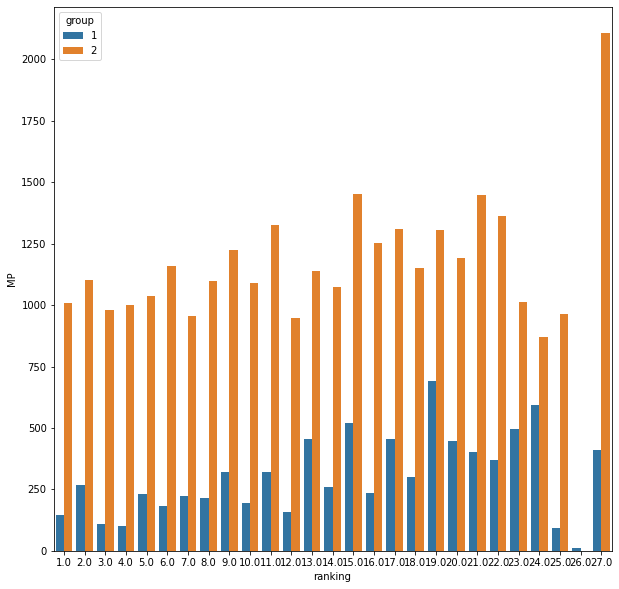

In [ ]:
df_tmranking[df_tmranking['Age']==23].groupby('ranking')['MP'].mean()
plt.figure(figsize=(10, 10))
sns.barplot(data=df_tmranking[(df_tmranking['Age']==23)].groupby(['ranking','group'])['MP'].mean().reset_index(),
              x='ranking',y='MP',hue='group')

(250.0, 2000.0)

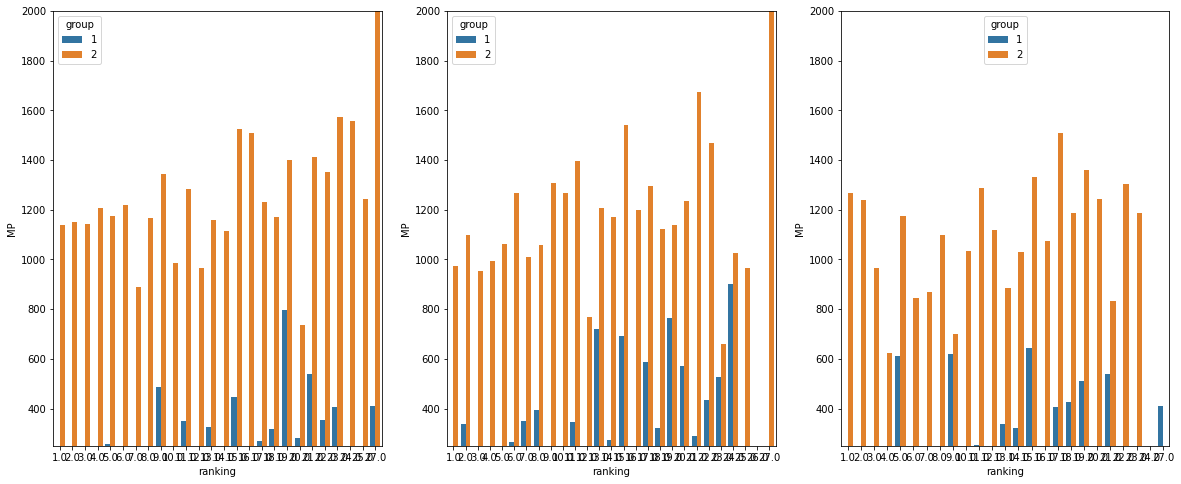

In [ ]:
plt.figure(figsize=(20, 8))
plt.subplot(131)
sns.barplot(data=df_tmranking[(df_tmranking['Age']==23)&(df_tmranking['position'].str.contains("F"))].groupby(['ranking','group'])['MP'].mean().reset_index(),
              x='ranking',y='MP',hue='group')
plt.ylim(250, 2000)
plt.subplot(132)
sns.barplot(data=df_tmranking[(df_tmranking['Age']==23)&(df_tmranking['position'].str.contains("G"))].groupby(['ranking','group'])['MP'].mean().reset_index(),
              x='ranking',y='MP',hue='group')
plt.ylim(250, 2000)
plt.subplot(133)
sns.barplot(data=df_tmranking[(df_tmranking['Age']==23)&(df_tmranking['position'].str.contains("C"))].groupby(['ranking','group'])['MP'].mean().reset_index(),
              x='ranking',y='MP',hue='group')
plt.ylim(250, 2000)

In [ ]:
aF = df_tmranking[(df_tmranking['Age']==23)&(df_tmranking['position'].str.contains("F"))].groupby(['ranking','group'])['MP'].mean().reset_index()
aG = df_tmranking[(df_tmranking['Age']==23)&(df_tmranking['position'].str.contains("G"))].groupby(['ranking','group'])['MP'].mean().reset_index()
aC = df_tmranking[(df_tmranking['Age']==23)&(df_tmranking['position'].str.contains("C"))].groupby(['ranking','group'])['MP'].mean().reset_index()
aF['position'] = 'F'
aG['position'] = 'G'
aC['position'] = 'C'


Text(0.5, 1.0, 'Group 2')

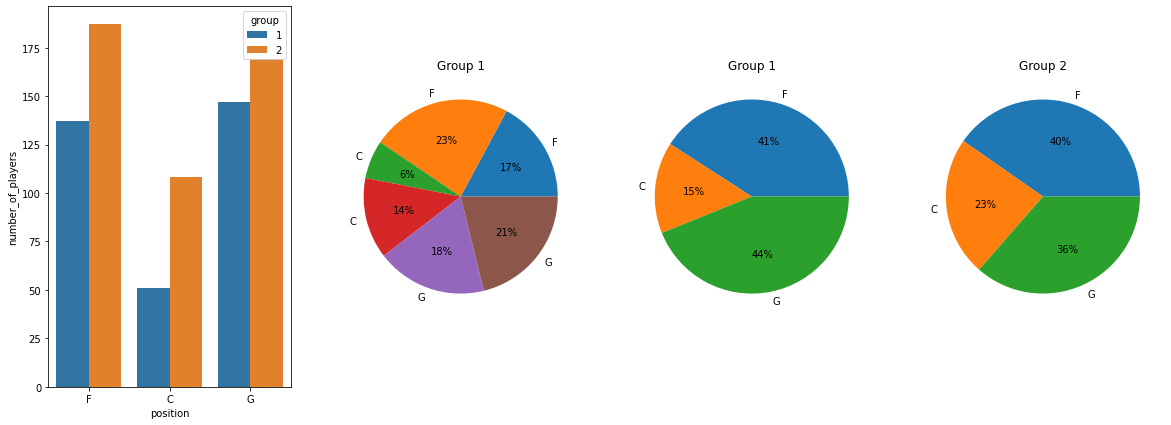

In [ ]:
dfleft1 = df_players[(df_players['position'].str.contains("F"))&(df_players['Age_draft']==24)].groupby('group')['position'].count()
dfright1 = df_players[(df_players['position'].str.contains("C"))&(df_players['Age_draft']==24)].groupby('group')['position'].count()
df3 = pd.merge(dfleft1, dfright1, how='inner', 
         left_index=True, right_index=True)
dfright3 = df_players[(df_players['position'].str.contains("G"))&(df_players['Age_draft']==24)].groupby('group')['position'].count()
df4 = pd.merge(df3, dfright3, how='inner', 
         left_index=True, right_index=True)
df4.columns = ['F','C','G']
df4 = df4.reset_index()
df4 = df4.melt(id_vars='group', 
              value_vars=['F','C','G'],
              var_name='position',
              value_name='number_of_players')
plt.figure(figsize=(20, 7))
plt.subplot(141)
sns.barplot(data=df4,
            x = 'position',
            y = 'number_of_players',
            hue = 'group')

plt.subplot(142)
plt.pie(df4['number_of_players'],labels = df4['position'], autopct = '%0.0f%%')
plt.title("Group 1")

plt.subplot(143)
plt.pie(df4[df4['group']==1]['number_of_players'],labels = df4[df4['group']==1]['position'], autopct = '%0.0f%%')
plt.title("Group 1")

plt.subplot(144)
plt.pie(df4[df4['group']==2]['number_of_players'],labels = df4[df4['group']==1]['position'], autopct = '%0.0f%%')
plt.title("Group 2")

In [ ]:
#các bảng phụ

#physical
#Changes in Physical stats when drafted between 2 groups with weight and height
df_height = df_players.groupby(['year_start','group'])['height'].mean().reset_index()
df_weight = df_players.groupby(['year_start','group'])['weight'].mean().reset_index()
#Age
DF_agedraft = df_players[df_players['year_start']<2016].groupby(['year_start','group'])['Age_draft'].mean().reset_index()
df_ageretired = df_players.groupby(['year_end','group'])['Age_retired'].mean().reset_index()
#Position
df_numberofplayer = df2

#Technique
#skill_ratio
df_skillsetall = pd.concat([df_playerstats[df_playerstats['position'].str.contains("F")].groupby('group')['BLK%','AST%','TRB%'].mean(), df_playerstats[df_playerstats['position'].str.contains("C")].groupby('group')['2P%','FT%','ORB%','DRB%','BLK%'].mean(), df_playerstats[df_playerstats['position'].str.contains("G")].groupby('group')['AST%','3P%','TOV%','STL%'].mean()], axis=0)
df_skillsetiny1 = pd.concat([df_seasons[(df_seasons['position'].str.contains("F"))&(df_seasons['year_play']==1)].groupby('group')['BLK%','AST%','TRB%'].mean(), df_seasons[(df_seasons['position'].str.contains("C"))&(df_seasons['year_play']==1)].groupby('group')['2P%','FT%','ORB%','DRB%','BLK%'].mean(), df_seasons[(df_seasons['position'].str.contains("G"))&(df_seasons['year_play']==1)].groupby('group')['AST%','3P%','TOV%','STL%'].mean()], axis=0)
df_skillsetiny2 = pd.concat([df_seasons[(df_seasons['position'].str.contains("F"))&(df_seasons['year_play']==2)].groupby('group')['BLK%','AST%','TRB%'].mean(), df_seasons[(df_seasons['position'].str.contains("C"))&(df_seasons['year_play']==2)].groupby('group')['2P%','FT%','ORB%','DRB%','BLK%'].mean(), df_seasons[(df_seasons['position'].str.contains("G"))&(df_seasons['year_play']==2)].groupby('group')['AST%','3P%','TOV%','STL%'].mean()], axis=0)
df_skillsetiny3 = pd.concat([df_seasons[(df_seasons['position'].str.contains("F"))&(df_seasons['year_play']==3)].groupby('group')['BLK%','AST%','TRB%'].mean(), df_seasons[(df_seasons['position'].str.contains("C"))&(df_seasons['year_play']==3)].groupby('group')['2P%','FT%','ORB%','DRB%','BLK%'].mean(), df_seasons[(df_seasons['position'].str.contains("G"))&(df_seasons['year_play']==3)].groupby('group')['AST%','3P%','TOV%','STL%'].mean()], axis=0)
#skill attempt
df_skillattall = pd.concat([(df_playerstats[df_playerstats['position'].str.contains("F")].groupby('group')['BLK','AST','TRB','MP','G'].mean()), (df_playerstats[df_playerstats['position'].str.contains("C")].groupby('group')['2P','FT','ORB','DRB','BLK','2PA','FTA','MP','G'].mean()),(df_playerstats[df_playerstats['position'].str.contains("G")].groupby('group')['AST','3P','TOV','STL','3PA','MP','G'].mean())],axis=0)
df_skillatty1 = pd.concat([(df_seasons[(df_seasons['position'].str.contains("F"))&(df_seasons['year_play']==1)].groupby('group')['BLK','AST','TRB','MP','G'].mean()),(df_seasons[(df_seasons['position'].str.contains("C"))&(df_seasons['year_play']==1)].groupby('group')['2P','FT','ORB','DRB','BLK','2PA','FTA','MP','G'].mean()),(df_seasons[(df_seasons['position'].str.contains("G"))&(df_seasons['year_play']==1)].groupby('group')['AST','3P','TOV','STL','3PA','MP','G'].mean())],axis=0)
df_skillatty2 = pd.concat([(df_seasons[(df_seasons['position'].str.contains("F"))&(df_seasons['year_play']==2)].groupby('group')['BLK','AST','TRB','MP','G'].mean()),(df_seasons[(df_seasons['position'].str.contains("C"))&(df_seasons['year_play']==2)].groupby('group')['2P','FT','ORB','DRB','BLK','2PA','FTA','MP','G'].mean()),(df_seasons[(df_seasons['position'].str.contains("G"))&(df_seasons['year_play']==2)].groupby('group')['AST','3P','TOV','STL','3PA','MP','G'].mean())],axis=0)
df_skillatty3 = pd.concat([(df_seasons[(df_seasons['position'].str.contains("F"))&(df_seasons['year_play']==3)].groupby('group')['BLK','AST','TRB','MP','G'].mean()),(df_seasons[(df_seasons['position'].str.contains("C"))&(df_seasons['year_play']==3)].groupby('group')['2P','FT','ORB','DRB','BLK','2PA','FTA','MP','G'].mean()),(df_seasons[(df_seasons['position'].str.contains("G"))&(df_seasons['year_play']==3)].groupby('group')['AST','3P','TOV','STL','3PA','MP','G'].mean())],axis=0)

#bangr chính

DF_agedraft
DF_minuteplay = df_seasons[df_seasons['year_play']<=3].groupby(['year_play','group'])['Age','G','MP','PER'].mean().reset_index()
DF_24sample = df_1
DF_ranking24 = pd.concat([aF,aG,aC],axis=0)
DF_numberofplayer24  = df4




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, u

In [ ]:
export_data_to_new_sheet('1rpW1i0EvY_zHzQHYJ7hxmw1AAb8EROcc3_2Frz4vxM0', 'DF_agedraft', DF_agedraft)
export_data_to_new_sheet('1rpW1i0EvY_zHzQHYJ7hxmw1AAb8EROcc3_2Frz4vxM0', 'DF_minuteplay', DF_minuteplay)
export_data_to_new_sheet('1rpW1i0EvY_zHzQHYJ7hxmw1AAb8EROcc3_2Frz4vxM0', 'DF_24sample', DF_24sample)
export_data_to_new_sheet('1rpW1i0EvY_zHzQHYJ7hxmw1AAb8EROcc3_2Frz4vxM0', 'DF_ranking24', DF_ranking24)
export_data_to_new_sheet('1rpW1i0EvY_zHzQHYJ7hxmw1AAb8EROcc3_2Frz4vxM0', 'DF_numberofplayer24', DF_numberofplayer24)
export_data_to_new_sheet('1rpW1i0EvY_zHzQHYJ7hxmw1AAb8EROcc3_2Frz4vxM0', 'df_height', df_height)
export_data_to_new_sheet('1rpW1i0EvY_zHzQHYJ7hxmw1AAb8EROcc3_2Frz4vxM0', 'df_weight', df_weight)
export_data_to_new_sheet('1rpW1i0EvY_zHzQHYJ7hxmw1AAb8EROcc3_2Frz4vxM0', 'df_ageretired', df_ageretired)
export_data_to_new_sheet('1rpW1i0EvY_zHzQHYJ7hxmw1AAb8EROcc3_2Frz4vxM0', 'df_numberofplayer', df_numberofplayer)
export_data_to_new_sheet('1rpW1i0EvY_zHzQHYJ7hxmw1AAb8EROcc3_2Frz4vxM0', 'df_skillsetall', df_skillsetall)
export_data_to_new_sheet('1rpW1i0EvY_zHzQHYJ7hxmw1AAb8EROcc3_2Frz4vxM0', 'df_skillsetiny1', df_skillsetiny1)
export_data_to_new_sheet('1rpW1i0EvY_zHzQHYJ7hxmw1AAb8EROcc3_2Frz4vxM0', 'df_skillsetiny2', df_skillsetiny2)
export_data_to_new_sheet('1rpW1i0EvY_zHzQHYJ7hxmw1AAb8EROcc3_2Frz4vxM0', 'df_skillsetiny3', df_skillsetiny3)
export_data_to_new_sheet('1rpW1i0EvY_zHzQHYJ7hxmw1AAb8EROcc3_2Frz4vxM0', 'df_skillattall', df_skillattall)
export_data_to_new_sheet('1rpW1i0EvY_zHzQHYJ7hxmw1AAb8EROcc3_2Frz4vxM0', 'df_skillatty1', df_skillatty1)
export_data_to_new_sheet('1rpW1i0EvY_zHzQHYJ7hxmw1AAb8EROcc3_2Frz4vxM0', 'df_skillatty2', df_skillatty2)
export_data_to_new_sheet('1rpW1i0EvY_zHzQHYJ7hxmw1AAb8EROcc3_2Frz4vxM0', 'df_skillatty3', df_skillatty3)